In [3]:
import numpy as np
import os
import csv
from typing import List, Dict, Tuple



In [4]:
#from moseq notebook
%pylab inline
from collections import OrderedDict
import pickle
import numpy as np
import seaborn as sns
from tqdm import trange

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from scipy.spatial.distance import pdist,squareform
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import warnings
warnings.filterwarnings('ignore') 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
data_dir = '/mnt/hd0/Pain_ML_data'
exp_groups = ['capsaicin','formalin','pbs']


exp_group_labels = LabelEncoder().fit_transform(exp_groups)
exp_group_str_to_label = {i:idx for idx,i in enumerate(exp_groups)}
label_binarizer = LabelBinarizer().fit(exp_group_labels)

n_samples = 500 # for bootstrap measurements

In [6]:
def get_kpms_filepaths(data_dir, exp_groups= []) -> Tuple[List[str], List[int]]:
    """
    Identifies kpms output files from data_dir and returns a list of all of their filepaths. If exp_groups is passed in then it will also return a list of each sample's 
    experimental group. Both these functions are dependent on data_dir having the appropriate directory structure

    :param data_dir: Root directory of all files
            ├── data_dir/
            |   ├── videos/
            |   │   ├── exp_group_1/
            |   │   │   ├── recording
            |   │   │   │   ├── trimmed_SN_grp2_0mins-2024-02-07_11-08-27-_chamber_2_body.avi
            |   │   │   │   ├── trimmed_SN_grp2_0mins-2024-02-07_11-08-27-_chamber_2_ftir.avi
            |   │   │   │   ├── trimmed_SN_grp2_0mins-2024-02-07_11-08-27-_chamber_2_bodyDLC_resnet50_arcteryx500Nov4shuffle1_350000-kpms.csv
            
    :param exp_groups (List[str]): Names of experimental groups to match for. These are expected to be 2 directories above the kpms output files
    
    :return: 
        :filepaths: List of absolute filepaths of all files in data_dir that end with 'kpms.csv'
        :file_labels: List of exp_groups for all kpms files in filepaths. Encoded as int based on exp_group_str_to_label
    
    """
    filepaths = []
    file_labels = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            # Identify kpms files
            if file.endswith('kpms.csv'): 
                filepath = os.path.join(root,file)
                dirname = os.path.basename(os.path.dirname(root))
                # Append to list
                filepaths.append(filepath)
                # Also append experimental group of sample if exp_groups is passed in
                if exp_groups:
                    if dirname in exp_groups:
                        file_labels.append(exp_group_str_to_label[dirname])
    return filepaths, file_labels
kpms_filepaths, kpms_labels = get_kpms_filepaths(data_dir, exp_groups)
# [print((os.path.basename(a),b)) for a,b in zip(kpms_filepaths,kpms_labels)]

In [7]:
len(kpms_labels)

55

In [8]:

def load_csv_column_to_list(filename, column_name) -> List:
    """
    Loads specific column from a csv file, returning it as a list
    """
    with open(filename, 'r', newline='') as file:
        reader = csv.reader(file)
        headers = next(reader)  # Read the header row
        
        if column_name is not None:
            column_index = headers.index(column_name)
        return [row[column_index] for row in reader]

recording_syllables = [load_csv_column_to_list(kpms_file,'syllable') for kpms_file in kpms_filepaths]

In [9]:

def extract_unique_syllables(list_of_kpms_filepaths: List[str]) -> Dict[str,int]:
    detected_syllables = {}
    for file in list_of_kpms_filepaths:
        # find unique vals
        recording_syllables = load_csv_column_to_list(file,'syllable')
        unique, counts = np.unique(recording_syllables, return_counts=True)
        # print(len(unique),len(counts))
        for u, c in zip(unique, counts):
            # add syllable and count if not in dict yet
            if u not in detected_syllables.keys():
                # print(f'adding syllable {u}')
                detected_syllables[u] = c
            else:
                # update count if syllable already in dict
                detected_syllables[u] += c
    return detected_syllables
    

In [10]:
def num_of_syllables_for_percentage_of_data (sorted_dict, percentage: float) -> int:
    """
    Calculates the number of syllables needed to explain a percentage of the total data

    :param sorted_dict: sorted dict of format <sorted_dict[syllable] = syllable_count> for all videos in dataset
    :param percentage: percent of data you want the syllables to explain, modulating the number of syllables returned by the function. Expecting values (0,100], not (0,1]
    
    :return: Minimum number of syllables needed to explain {percentage} percent of the data
    """
    # Calculate the total count
    total_count = sum(list(sorted_dict.values())) #added list because total_count was being assigned a dict not a single number
    
    # Calculate cumulative sum and percentage
    cumulative_sum = np.cumsum(list(sorted_dict.values()))
    cumulative_percentage = (cumulative_sum / total_count) * 100
    
    return np.argmax(cumulative_percentage >= percentage) + 1

def get_top_syllables(data_dir: str, percent: float) -> List[str]:
    # get syllable counts across all videos
    kpms_filepaths, __ = get_kpms_filepaths(data_dir)
    detected_syllables = extract_unique_syllables(kpms_filepaths)
    # sort syllable dict by count values
    sorted_dict = dict(sorted(detected_syllables.items(), key=lambda item: item[1], reverse=True))
    num_syllables_needed = num_of_syllables_for_percentage_of_data(sorted_dict, percent)
    top_syllables = list(sorted_dict.keys())[:num_syllables_needed]
    
    return top_syllables

syllable_map = get_top_syllables(data_dir,98)
print(syllable_map)

['2', '0', '1', '5', '6', '3', '4', '12', '7', '11', '13', '15', '9', '8', '16', '10', '22', '17', '21', '19', '14']


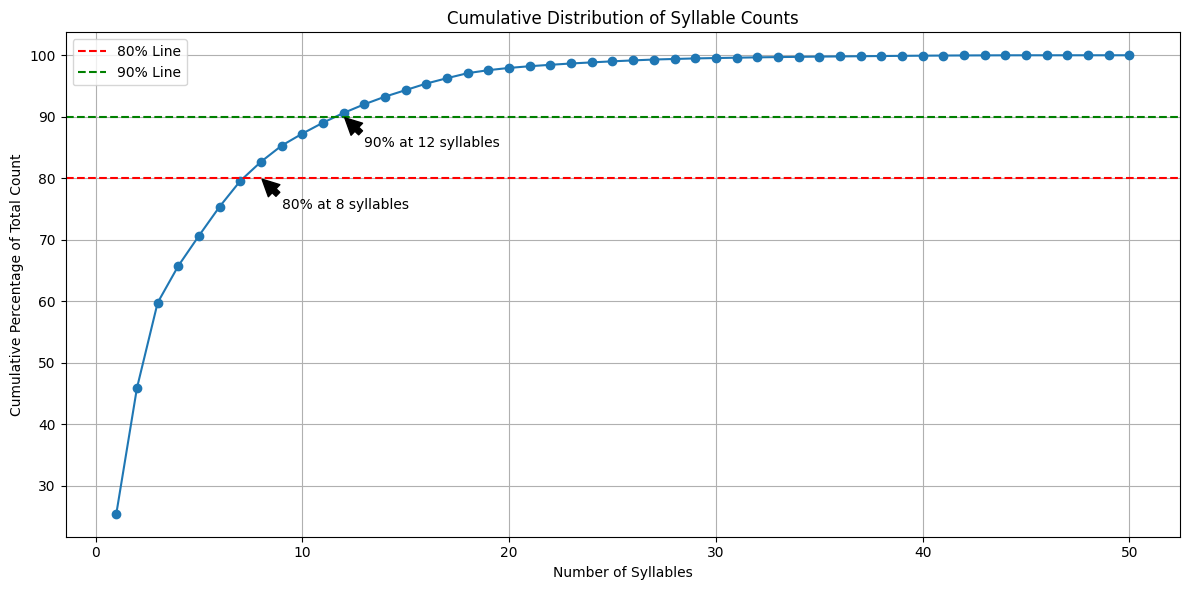

Total number of syllables: 50
Number of syllables needed to reach 80% of total count: 8
Number of syllables needed to reach 90% of total count: 12

Top 10 most frequent syllables:
1. Syllable 2: 188703 (25.41%)
2. Syllable 0: 152053 (20.48%)
3. Syllable 1: 102917 (13.86%)
4. Syllable 5: 44465 (5.99%)
5. Syllable 6: 36472 (4.91%)
6. Syllable 3: 35140 (4.73%)
7. Syllable 4: 31092 (4.19%)
8. Syllable 12: 23080 (3.11%)
9. Syllable 7: 19482 (2.62%)
10. Syllable 11: 14483 (1.95%)


In [11]:
import matplotlib.pyplot as plt
import numpy as np

#from abve fn
kpms_filepaths, __ = get_kpms_filepaths(data_dir)
detected_syllables = extract_unique_syllables(kpms_filepaths)
sorted_dict = dict(sorted(detected_syllables.items(), key=lambda item: item[1], reverse=True))

# Calculate the total count
total_count = sum(list(sorted_dict.values()))

# Calculate cumulative sum and percentage
cumulative_sum = np.cumsum(list(sorted_dict.values()))
cumulative_percentage = (cumulative_sum / total_count) * 100

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(sorted_dict) + 1), cumulative_percentage, marker='o')
plt.xlabel('Number of Syllables')
plt.ylabel('Cumulative Percentage of Total Count')
plt.title('Cumulative Distribution of Syllable Counts')
plt.grid(True)

# Add reference lines
plt.axhline(y=80, color='r', linestyle='--', label='80% Line')
plt.axhline(y=90, color='g', linestyle='--', label='90% Line')

# Annotate the number of syllables needed to reach 80% and 90%
syllables_80 = np.argmax(cumulative_percentage >= 80) + 1
syllables_90 = np.argmax(cumulative_percentage >= 90) + 1

plt.annotate(f'80% at {syllables_80} syllables', xy=(syllables_80, 80), xytext=(syllables_80+1, 75),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'90% at {syllables_90} syllables', xy=(syllables_90, 90), xytext=(syllables_90+1, 85),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Total number of syllables: {len(sorted_dict)}")
print(f"Number of syllables needed to reach 80% of total count: {syllables_80}")
print(f"Number of syllables needed to reach 90% of total count: {syllables_90}")

# Print top 10 most frequent syllables
print("\nTop 10 most frequent syllables:")
for i, (syllable, count) in enumerate(list(sorted_dict.items())[:10], 1):
    percentage = (count / total_count) * 100
    print(f"{i}. Syllable {syllable}: {count} ({percentage:.2f}%)")

In [12]:
def get_syllables_freqs(syllable_seq: List[str], syllable_map: List[str]):
    
    # Initialize freqs array in same shape as syllable_map
    freqs = np.zeros(len(syllable_map))

    # Get unique values and counts of every value in syllable_seq
    num_syllables = len(syllable_seq)
    syllables, counts = np.unique(syllable_seq, return_counts=True)
    
    for s,c in zip(syllables,counts):
        #if unique syllable_seq in syllable_map
        if s in syllable_map:
            index = syllable_map.index(s)
            freqs[index] = c / num_syllables
    return freqs
            
get_syllables_freqs(recording_syllables[0], syllable_map)

array([0.14103704, 0.25288889, 0.18918519, 0.10792593, 0.01503704,
       0.04777778, 0.0597037 , 0.01511111, 0.02948148, 0.00340741,
       0.06888889, 0.01081481, 0.02081481, 0.002     , 0.002     ,
       0.00451852, 0.        , 0.00785185, 0.00096296, 0.        ,
       0.00792593])

In [13]:
syllable_freqs = np.array([get_syllables_freqs(recording, syllable_map) for recording in recording_syllables])
print(syllable_freqs[0])

[0.14103704 0.25288889 0.18918519 0.10792593 0.01503704 0.04777778
 0.0597037  0.01511111 0.02948148 0.00340741 0.06888889 0.01081481
 0.02081481 0.002      0.002      0.00451852 0.         0.00785185
 0.00096296 0.         0.00792593]


## Moseq notebook

In [14]:
def train_linear_classifier(features, labels, C=100.0, n_fold=1, test_size=0.2, seed=0):

    splits = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)\
               .split(features, labels)
    train_ind, test_ind = next(splits)
    model = LogisticRegression(penalty='l2', C=C, solver='lbfgs', multi_class='ovr', class_weight='balanced')
    model.fit(features[train_ind], labels[train_ind])
    pred_labels = model.predict(features[test_ind])
    scores = model.predict_proba(features[test_ind])
    true_labels = labels[test_ind]

    return true_labels, pred_labels, scores

In [15]:
label_level = 'drug' # also valid: class, dose
feature_types = ['kpms']#'pain_behaviors'] # 'scalars', 'shuffled_moseq']
# y = fingerprint_labels[f'y_{label_level}']
y = np.array(kpms_labels)
unique_labels = exp_groups
n_labels = len(unique_labels)
# label_binarizer = LabelBinarizer().fit(np.arange(n_labels))
n_samples = 500 # for bootstrap measurements

In [282]:
precisions = OrderedDict(())
recalls = OrderedDict(())
f1s = OrderedDict(())


for feature_type in feature_types:
    print(f'Working on {feature_type}')
    
    # x = fingerprints[feature_type]
    x = syllable_freqs
        
    f1s[feature_type] = []
    all_true_labels = []
    all_scores = []
    
    for iseed in trange(n_samples):
        true_labels, pred_labels, scores = train_linear_classifier(x, y, seed=iseed)
        all_true_labels.append(label_binarizer.transform(true_labels))
        all_scores.append(scores)
        
        per_label_f1 = f1_score(true_labels, pred_labels, average=None)
        f1s[feature_type].append(per_label_f1)
    
    precisions[feature_type], recalls[feature_type], _ = precision_recall_curve(
        np.array(all_true_labels).ravel(), np.array(all_scores).ravel()
    )
    f1s[feature_type] = np.mean(f1s[feature_type], axis=0) # average over seeds

Working on kpms


100%|███████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.76it/s]


#### Plotting utilities and settings

In [283]:
# Plotting 
def make_label(feature_type):
    return f'{feature_type} F1: {np.mean(f1s[feature_type]):.2f} ± {np.std(f1s[feature_type])/np.sqrt(n_labels):.2f}'
    return f'{feature_type} F1: {np.mean(f1s[feature_type]):.2f} ± {np.std(f1s[feature_type])/np.sqrt(n_labels):.2f}'

feature_color = {
    'scalars': '#B4AD33',
    'kpms': '#7C449A',
    'shuffled_moseq': '#7C449A',
}

feature_mark = {
    'scalars': '-',
    'kpms': '-',
    'shuffled_moseq': '--',
}

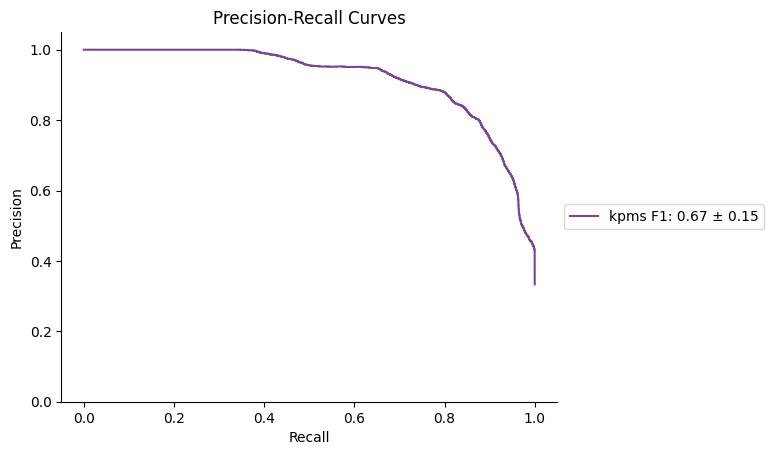

In [284]:
for feature_type in feature_types:
    label = make_label(feature_type)
    plot(recalls[feature_type], precisions[feature_type],
         label=label, color=feature_color[feature_type], 
         linestyle=feature_mark[feature_type])
title('Precision-Recall Curves')
xlabel('Recall')
ylabel('Precision')
ylim(0, 1.05)
legend(loc='center left', bbox_to_anchor=[1,0.5])
sns.despine()

In [285]:
cosine = lambda data: squareform(pdist(data,metric='cosine'))

def sim_matrix_of_avgs(data,labels):
    # Get the per-label average of the data
    unique_labels = np.unique(labels)
    out = np.zeros((len(unique_labels),len(unique_labels)),dtype='float32')
    means = np.zeros((len(unique_labels),data.shape[1]))
    for ilabel in unique_labels:
        means[ilabel] = np.nanmean(data[labels==ilabel],0)
    return cosine(means)

def show_cosine(data):
    return imshow(sim_matrix_of_avgs(data, y),
                  cmap='viridis_r',
                  clim=(0,1.0),
                  interpolation=None); axis('square')


short_name_map = OrderedDict([
    ('capsaicin','CAP'),
    ('formalin','FOR'),
    ('pbs','PBS'),

])
short_names = [short_name_map[u] for u in unique_labels]

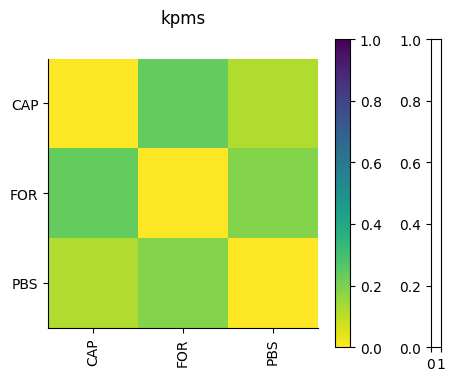

In [286]:
figure(figsize=(10,4))
gs = GridSpec(1,3, width_ratios=[10,10,0.3])

# ax = subplot(gs[0])
# cax = show_cosine(fingerprints['scalars'])
# title('Scalars', y=1.1)
# xticks(range(len(short_names)), short_names, rotation=90)
# yticks(range(len(short_names)), short_names)
# sns.despine()

ax = subplot(gs[1])
show_cosine(x)
title('kpms',y=1.1)
xticks(range(len(short_names)), short_names, rotation=90)
yticks(range(len(short_names)), short_names)
sns.despine()

ax = subplot(gs[2])
# colorbar(ax, cax=ax);
colorbar()